## Density of brine

From Batzle and Wang 1992, as given by Kumar in Geohorizons, January 2006.

In [59]:
import numpy as np

def _rho_water(temperature, pressure):
    """
    The density of pure water, as a function of temperature t and
    pressure p.
    
    Args:
        temperature (float): The temperature in degrees Celsius.
        pressure (float): The pressure in pascals.
        
    Returns:
        float: The density in kg/m3.
    """
    T, P = np.asanyarray(temperature), np.asanyarray(pressure)*1e-6
    x = -80*T - 3.3*T**2 + 0.00175*T**3 + 489*P - 2*T*P \
        + 0.016*P*T**2 - 1.3e-5*P*T**3 - 0.333*P**2 - 0.002*T*P**2
    return 1000 + 1e-3 * x

def rho_brine(temperature, pressure, salinity):
    """
    The density of NaCl brine, given temperature, pressure, and
    salinity. The density of pure water is computed from _rho_water().
    
    Args:
        temperature (float): The temperature in degrees Celsius.
        pressure (float): The pressure in pascals.
        salinity (float): The weight fraction of NaCl, e.g. 35e-3
            for 35 parts per thousand, or 3.5% (the salinity of
            seawater).
    Returns:
        float: The density in kg/m3.
    """
    # Align with the symbols and units in Batzle & Wang.
    T, P = np.asanyarray(temperature), np.asanyarray(pressure)*1e-6
    S = np.asanyarray(salinity)
    
    x = 300*P - 2400*P*S + T*(80 + 3*T - 3300*S - 13*P + 47*P*S)
    rho_water = _rho_water(temperature, pressure) / 1000
    return 1000 * (rho_water + S*(0.668 + 0.44*S + 1e-6 * x))

In [60]:
_rho_water([20, 25, 30], 9.81e6)

array([1001.52455769, 1000.33068267,  998.9857399 ])

In [61]:
rho_brine(100, 49e6, 240e-3)

1151.341787

These seem to agree with Figure 13.

## Velocity of brine

In [62]:
import numpy as np

def v_water(temperature, pressure):
    """
    The acoustic velocity of pure water, as a function of temperature
    and pressure.
    
    Note that this function does not work at pressures above about
    100 MPa.
    
    Args:
        temperature (float): The temperature in degrees Celsius.
        pressure (float): The pressure in pascals.
        
    Returns:
        float: The velocity in m/s.
    """
    w = np.array([[ 1.40285e+03,  1.52400e+00,  3.43700e-03, -1.19700e-05],
                  [ 4.87100e+00, -1.11000e-02,  1.73900e-04, -1.62800e-06],
                  [-4.78300e-02,  2.74700e-04, -2.13500e-06,  1.23700e-08],
                  [ 1.48700e-04, -6.50300e-07, -1.45500e-08,  1.32700e-10],
                  [-2.19700e-07,  7.98700e-10,  5.23000e-11, -4.61400e-13]])

    T, P = np.asanyarray(temperature), np.asanyarray(pressure) * 1e-6
    return sum(w[i, j] * T**i * P**j for i in range(5) for j in range(4))

Reproduce figure 12

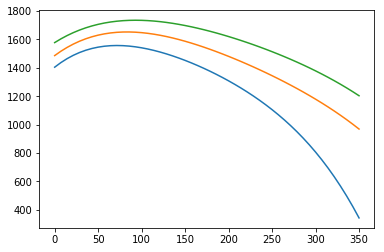

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

T = np.linspace(0, 350)
for P in [1, 50, 100]:
    V = v_water(T, P*1e6)
    plt.plot(T, V)

In [64]:
def v_brine(temperature, pressure, salinity):
    # Align with the symbols and units in Batzle & Wang.
    T, P = np.asanyarray(temperature), np.asanyarray(pressure)*1e-6
    S = np.asanyarray(salinity)
    
    v_w = v_water(temperature, pressure)
    s1 = S * (1170 - 9.6*T + 0.055*T**2 - 8.5e-5*T**3 + 2.6*P - 0.0029*T*P - 0.0476*P**2)
    s15 = S**1.5 * (780 - 10*P + 0.16*P**2)
    s2 = -820 * S**2
    
    return v_w + s1 + s15 + s2

In [65]:
v_brine(25, 100e6, 35e-3)

1691.113778370309

Reproduce figure 14.

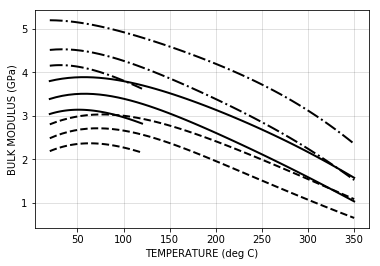

In [67]:
from bruges.rockphysics import moduli

for P in [0.1e6, 50e6, 100e6]:
    for S, ls in zip([0, 150e-3, 300e-3], ['--', '-', '-.']):
        if P == 0.1e6:
            T = np.linspace(20, 120)
        else:
            T = np.linspace(20, 350)
        v = v_brine(T, P, S)
        rho = rho_brine(T, P, S)
        bulk = moduli.bulk(vp=v, vs=0, rho=rho) / 1e9
        plt.plot(T, bulk, ls, color='k', lw=2)
plt.xlabel('TEMPERATURE (deg C)')
plt.ylabel('BULK MODULUS (GPa)')
plt.grid(color='k', alpha=0.15)

In [69]:
moduli.bulk(vp=1500, vs=0, rho=1000) 

2250000000.0